In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.rcParams["lines.markersize"] = 9.0

from pydftlj.dft import DFT

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2024-09-30

# LJ Fluid Near Hardwall

## Defining the Functionals

MFA: Mean Field Approximation
WDA: Weigthed Density Approximation
MMFA: Modified Mean-Field Approximation

In [2]:
DFTMFA = DFT(ndim=1,functional='WBI+MFA',padding=True)
DFTWDA = DFT(ndim=1,functional='WBI+WDA',padding=True)
DFTMMFA = DFT(ndim=1,functional='WBI+MMFA',padding=True)

DFTs = [DFTMFA,DFTWDA,DFTMMFA]

### Define the Fluid Properties

In [3]:
sigmaff = 1.0
epsilonff = 1.0

In [4]:
for DFT in DFTs:
    DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff,cut_off=5*sigmaff)

### Defining the Slab Geometry

In [5]:
L = 20*sigmaff

In [6]:
for DFT in DFTs:
    DFT.Set_Gridsize(gridsize=0.01)
    DFT.Set_Geometry(box_dimensions=L)

### Defining the Temperature

In [7]:
kT = 1.35 

In [8]:
for DFT in DFTs:
    DFT.Set_Temperature(kT)

### Defining the External Potential of Hard Wall

In [9]:
for DFT in DFTs:
    Vext = np.zeros(DFT.Ngrid[0])
    Vext[DFT.X < 0.5*DFT.d] = np.inf # can be infinite, no problem
    Vext[DFT.X > L-0.5*DFT.d] = np.inf
    DFT.Set_External_Potential(Vext)

(0.0, 20.0)

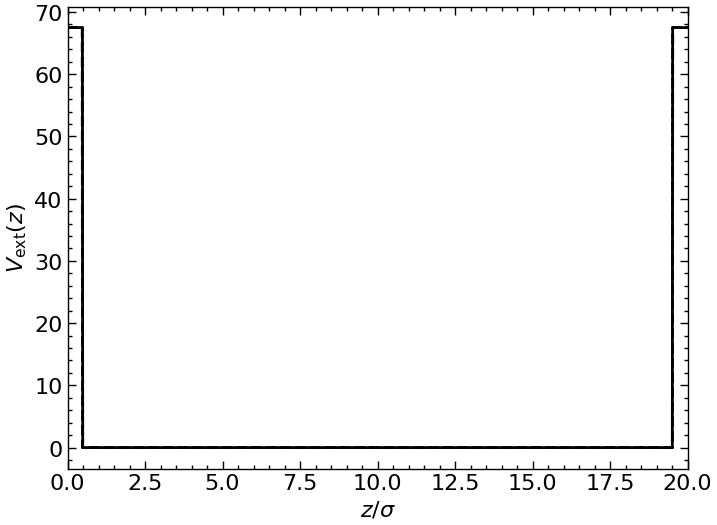

In [10]:
plt.plot(DFTMFA.X,DFTMFA.Vext.cpu(),':',color='k',label='MFA')
plt.plot(DFTWDA.X,DFTWDA.Vext.cpu(),'--',color='k',label='WDA')
plt.plot(DFTMMFA.X,DFTMMFA.Vext.cpu(),'-',color='k',label='MMFA')

plt.ylabel(r'$V_\text{ext}(z)$')
plt.xlabel(r'$z/\sigma$')

plt.xlim(0,L)

### Setting the bulk density

In [11]:
rhob = 0.5

for DFT in DFTs:
    DFT.Set_BulkDensity(rhob)
    DFT.Set_InitialCondition()

### Defining the Equilibrium solver and calculate equilibrium profile

In [13]:
for DFT in DFTs:
    DFT.Set_Solver_Equilibrium(solver='abc-fire',alpha=0.15,dt=0.01)
    DFT.Calculate_Equilibrium()

Text(0, 0.5, '$\\rho(z)\\sigma$')

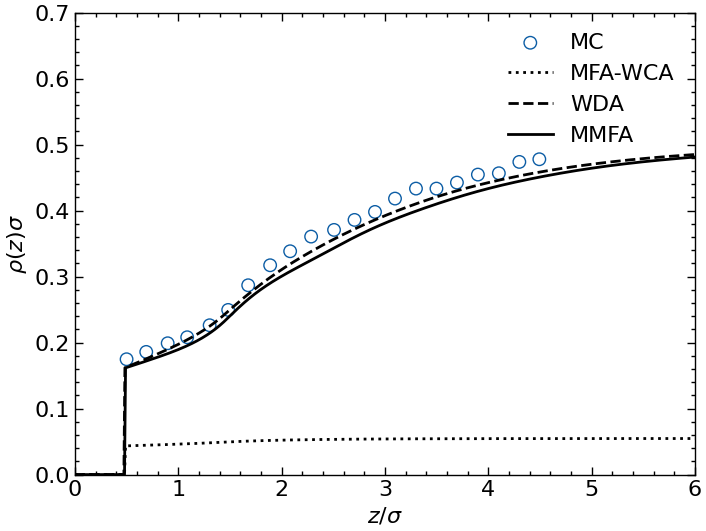

In [14]:
dataMC = np.loadtxt('../examples/data/MC/lj-hardwall-rhob0.5-T1.35.dat')

plt.scatter(dataMC.T[0]+0.5,dataMC.T[1],marker='o',edgecolors='C0',facecolors='none',label='MC')
plt.plot(DFTMFA.X,DFTMFA.rho.cpu(),':',color='k',label='MFA-WCA')
plt.plot(DFTWDA.X,DFTWDA.rho.cpu(),'--',color='k',label='WDA')
plt.plot(DFTMMFA.X,DFTMMFA.rho.cpu(),'-',color='k',label='MMFA')
plt.legend(loc='best')
plt.ylim(0,0.7)
plt.xlim(0.0,6)
plt.xlabel(r'$z/\sigma$')
plt.ylabel(r'$\rho(z)\sigma$')

In [15]:
rhob = 0.65

for DFT in DFTs:
    DFT.Set_BulkDensity(rhob)
    DFT.Set_InitialCondition()
    DFT.Calculate_Equilibrium()

Text(0, 0.5, '$\\rho(z)\\sigma^3$')

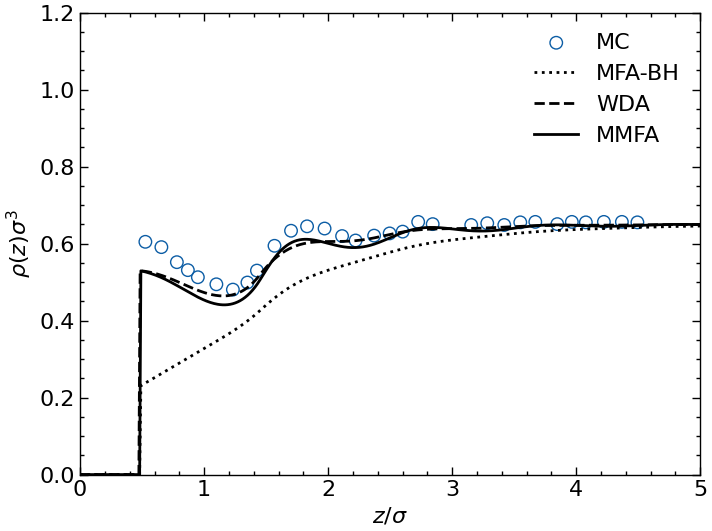

In [16]:
dataMC = np.loadtxt('../examples/data/MC/lj-hardwall-rhob0.65-T1.35.dat')

plt.scatter(dataMC.T[0]+0.5,dataMC.T[1],marker='o',edgecolors='C0',facecolors='none',label='MC')
plt.plot(DFTMFA.X,DFTMFA.rho.cpu(),':',color='k',label='MFA-BH')
plt.plot(DFTWDA.X,DFTWDA.rho.cpu(),'--',color='k',label='WDA')
plt.plot(DFTMMFA.X,DFTMMFA.rho.cpu(),'-',color='k',label='MMFA')
plt.ylim(0,1.2)
plt.xlim(0.0,5)
plt.legend(loc='best')
plt.xlabel(r'$z/\sigma$')
plt.ylabel(r'$\rho(z)\sigma^3$')

In [17]:
rhob = 0.82

for DFT in DFTs:
    DFT.Set_BulkDensity(rhob)
    DFT.Set_InitialCondition()
    DFT.Calculate_Equilibrium()

Text(0, 0.5, '$\\rho(z)\\sigma^3$')

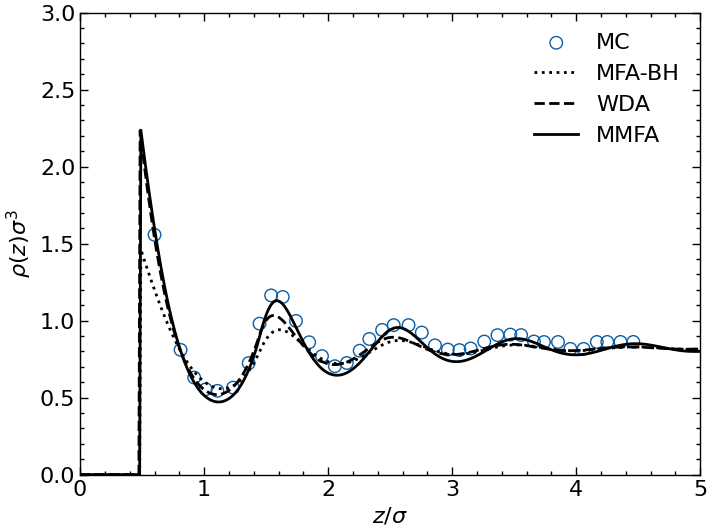

In [18]:
dataMC = np.loadtxt('../examples/data/MC/lj-hardwall-rhob0.82-T1.35.dat')

plt.scatter(dataMC.T[0]+0.5,dataMC.T[1],marker='o',edgecolors='C0',facecolors='none',label='MC')
plt.plot(DFTMFA.X,DFTMFA.rho.cpu(),':',color='k',label='MFA-BH')
plt.plot(DFTWDA.X,DFTWDA.rho.cpu(),'--',color='k',label='WDA')
plt.plot(DFTMMFA.X,DFTMMFA.rho.cpu(),'-',color='k',label='MMFA')
plt.ylim(0,3)
plt.xlim(0.0,5)
plt.legend(loc='best')
plt.xlabel(r'$z/\sigma$')
plt.ylabel(r'$\rho(z)\sigma^3$')

# LJ fluid Confined in SlitPore with Steele Potential

In [19]:
for DFT in DFTs:
    DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff,cut_off=3.5*sigmaff)

### The Steele External Potential

In [20]:
# Parameters of the Steele potential 
epsilonw = 2*np.pi*epsilonff
Delta = sigmaff/np.sqrt(2)
sigmaw = sigmaff

def Vsteele(z):
    return epsilonw*(0.4*(sigmaw/z)**10-(sigmaw/z)**4-sigmaw**4/(3*Delta*(z+0.61*Delta)**3)) 

### Defining the bulk properties

In [21]:
kT = 1.2
rhob = 0.5925

In [22]:
for DFT in DFTs:
    DFT.Set_Geometry(box_dimensions=10.0)
    DFT.Set_Temperature(kT)
    DFT.Set_BulkDensity(rhob)

In [23]:
Lz = [7.5,4.0,3.0,1.8]

z = []
rhoz = []

for lz in Lz:
    print(lz)
    for DFT in DFTs:
        Vext = np.zeros(DFT.Ngrid[0])
        Vext[:] = Vsteele(DFT.X) + Vsteele(lz-DFT.X)
        Vext[DFT.X > lz] = np.inf
        Vext[DFT.X < 0.0] = np.inf

        DFT.Set_External_Potential(Vext)
        DFT.Set_InitialCondition()
        DFT.Set_Solver_Equilibrium(solver='abc-fire',alpha=0.15,dt=0.01)
        DFT.Calculate_Equilibrium()

        z.append(DFT.X)
        rhoz.append(DFT.rho.cpu())

7.5
4.0
3.0
1.8


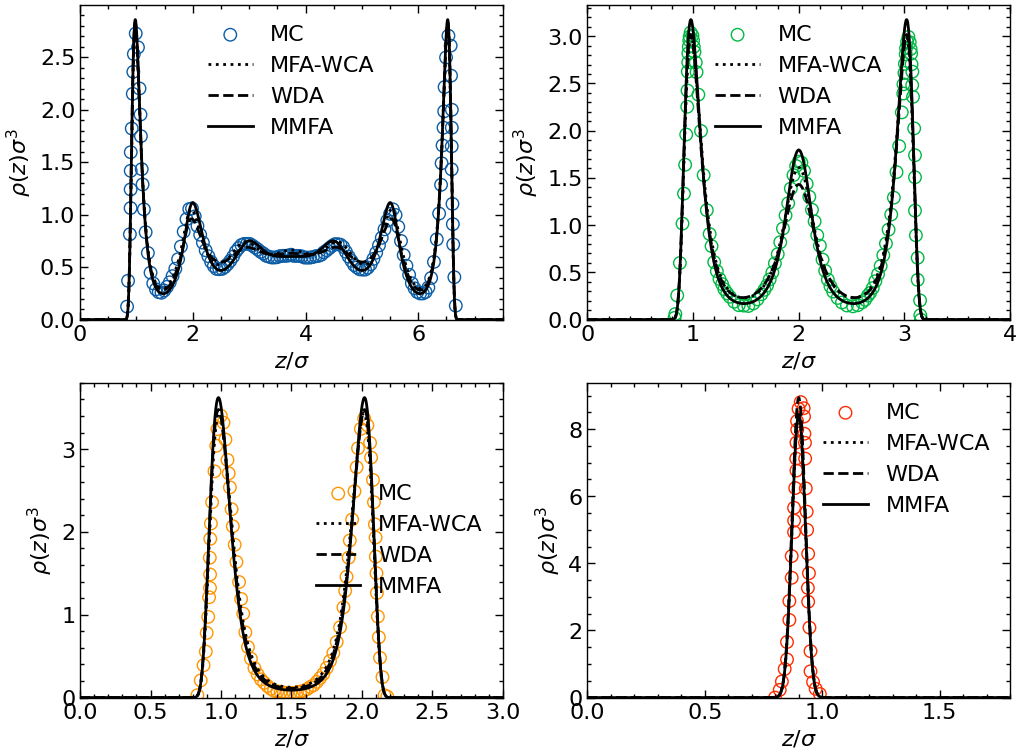

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

colors = ['C0','C1','C2','C3']
lines = [':','--','-']
names = ['MFA-WCA','WDA','MMFA']

# loop through tickers and axes
for i, ax in zip(range(len(Lz)), axs.ravel()):
    dataMC = np.loadtxt(f'../examples/data/MC/lj-slitpore-steele-T1.2-rhob0.5925-H{Lz[i]:.1f}-GEMC.dat')

    ax.scatter(dataMC.T[0],dataMC.T[1],marker='o',edgecolors=colors[i],facecolors='none',label='MC')

    for j in range(3):
        ax.plot(z[3*i+j],rhoz[3*i+j],ls=lines[j],color='k',label=names[j])

    # chart formatting
    ax.set_xlabel(r'$z/\sigma$')
    ax.set_ylabel(r'$\rho(z)\sigma^3$')
    ax.set_xlim(0.0,Lz[i])
    # ax.set_ylim(0.0,10)
    ax.set_ylim(bottom=0.0)
    ax.legend(loc='best')